## **Desciminative-Localization using Class Activation Mapping**

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [26]:
dataset = OxfordIIITPet(root='./data', download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [27]:
model = resnet18(pretrained=True)
model.fc = torch.nn.Linear(model.fc.in_features, 37)
target_layer = model.layer4[-1]
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
feature_maps = None
def hook_fn(module, input, output):
    global feature_maps
    feature_maps = output
target_layer.register_forward_hook(hook_fn)

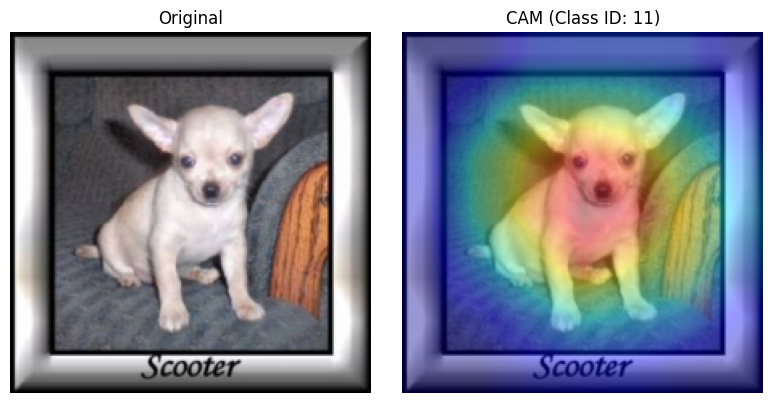

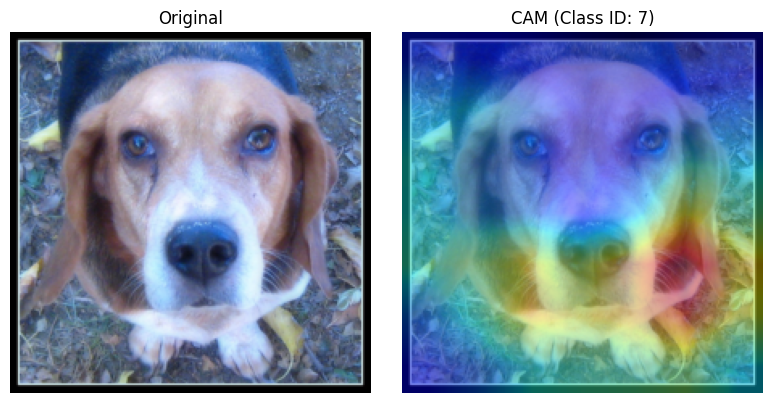

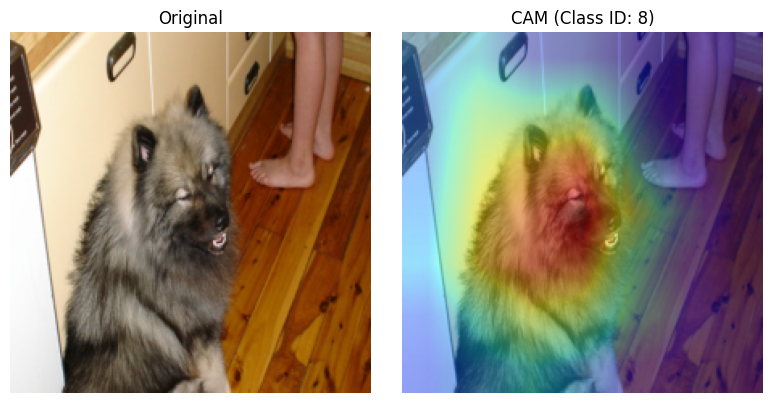

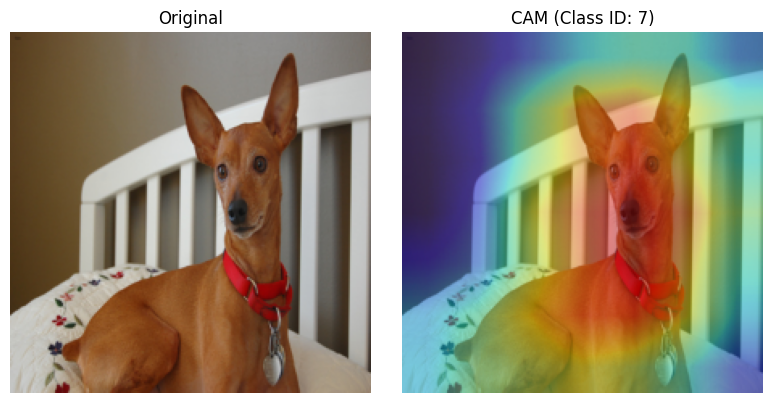

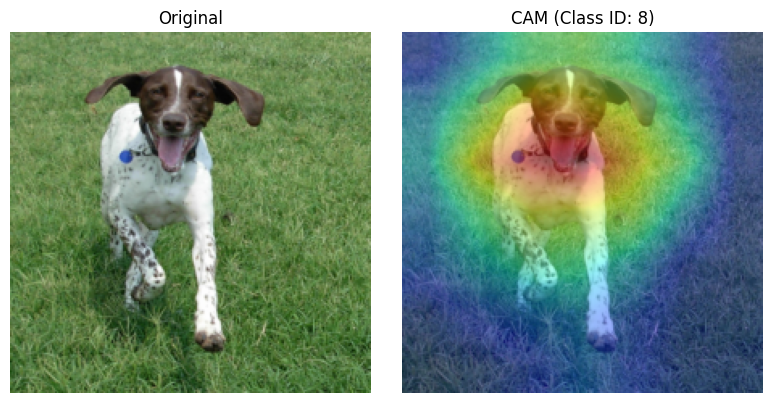

In [29]:
count = 0
for images, labels in dataloader:
    outputs = model(images)
    _, pred = outputs.max(1)

    weights = model.fc.weight.data
    cam = (weights[pred.item()].unsqueeze(1).unsqueeze(2) * feature_maps[0]).sum(0).detach().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    cam = np.uint8(255 * cam)

    from PIL import Image as PILImage
    cam = PILImage.fromarray(cam).resize((224, 224), PILImage.BILINEAR)
    cam = np.array(cam)

    img = images[0].permute(1, 2, 0).numpy()
    img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img = np.clip(img, 0, 1)

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(img)
    axs[0].set_title("Original")
    axs[0].axis('off')
    axs[1].imshow(img)
    axs[1].imshow(cam, cmap='jet', alpha=0.4)
    axs[1].set_title(f"CAM (Class ID: {pred.item()})")
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

    count += 1
    if count == 5:
        break
